In [1]:
setwd("E:\\PVN_Sequencing\\NEW_PVN_2016_Aligned83\\New_aligned_F1_Tophat83")
data<- read.csv("cd_F1_PVN_NEW_zero_elim_filtered_OUTLIERS_lncRNA_ensRM_Names83_try2.csv", header=TRUE, row.names=1)

In [2]:
library(RUVSeq)
x <- as.factor(c(1,1,1,1,1,2,2,2,2,2))
set <- newSeqExpressionSet(as.matrix(data),
			phenoData = data.frame(x, row.names=colnames(data)))
genes <- rownames(data)		
libSizes <- as.vector(colSums(data))	

### RUV visualization 
library(RColorBrewer)
colors <- brewer.pal(3, "Set2")

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To c

In [3]:
### RUVr normalize the data by residuals
design<- model.matrix(~x, data=pData(set))
y <- DGEList(counts=counts(set), group=x)
y <- calcNormFactors(y,method="upperquartile")
y <- estimateGLMCommonDisp(y, design)
y <- estimateGLMTagwiseDisp(y, design)
fit <- glmFit(y, design)
res <- residuals(fit, type="deviance")
set1<- RUVr(set, genes, k=1, res)

In [5]:
### EdgeR analysis on RUVr data to determine which genes are significantly differentialy expressed between control
### treatment groups
library(edgeR)
design<- model.matrix(~x + W_1, data=pData(set1))
d <- DGEList(counts=counts(set1),group=x)
d <- calcNormFactors(d, method="upperquartile")
d <- estimateGLMCommonDisp(d, design,verbose=T)
#Output: Disp = 0.01897 , BCV = 0.1377 
d <- estimateGLMTagwiseDisp(d, design)
fit <- glmFit(d, design)
lrt <- glmLRT(fit, coef=2)
topTags(lrt)

## The following are the genes that have changed the most significantly
summary(decideTestsDGE(lrt, adjust.method= "fdr", p.value=0.05))

Disp = 0.01913 , BCV = 0.1383 


,logFC,logCPM,LR,PValue,FDR
MED12,0.8626043,5.498692,63.45850,1.637813e-15,1.996985e-11
ZFHX4,1.0363027,5.722267,61.07322,5.499119e-15,3.352538e-11
KAT6A,0.8279389,5.881583,56.41721,5.861518e-14,2.382316e-10
RXFP1,1.3927176,2.035348,54.77523,1.351330e-13,4.119193e-10
KDM6B,0.8567483,3.945636,50.28628,1.328750e-12,3.240290e-09
CHD2,0.7563440,5.179893,49.44686,2.038183e-12,4.141928e-09
CBLN4,-0.8358243,5.960864,47.18104,6.472347e-12,1.127390e-08
SETBP1,0.8524533,3.942622,44.77792,2.206969e-11,3.363696e-08
ZMIZ1,0.6941925,6.329909,43.27934,4.745689e-11,6.429354e-08
NRXN3,1.1198475,5.300503,41.81886,1.001327e-10,1.113626e-07


   [,1] 
-1   173
0  11423
1    597

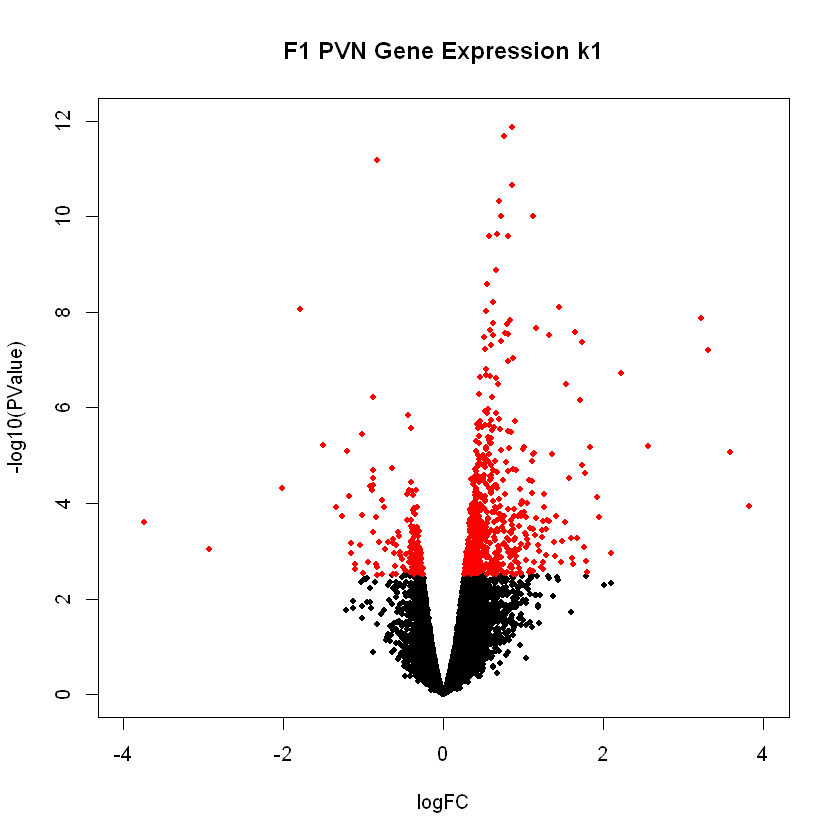

In [6]:
## Make Processed Data Table
abc<-as.data.frame(normCounts(set1))
abc$twd <- d$tagwise.dispersion
abc<- cbind(abc, lrt$table)
abc$PValue_fdr <- p.adjust(method="fdr",p=abc$PValue)
write.table(abc, file="F1EDGER_RUVr__LRT_OutliersElim_count_PVN_k1_wNormCounts.csv", sep=",",quote=F)

# Make a basic volcano plot
with(abc, plot(logFC, -log10(PValue), pch=20, main="F1 PVN Gene Expression k1", xlim=c(-4,4), ylim=c(0,12)))

# Add colored points: red if PValue_fdr<0.05)
with(subset(abc, PValue_fdr<.05 ), points(logFC, -log10(PValue), pch=20, col="red"))



Warning message:
"package 'gplots' was built under R version 3.2.5"
Attaching package: 'gplots'

The following object is masked from 'package:IRanges':

    space

The following object is masked from 'package:stats':

    lowess



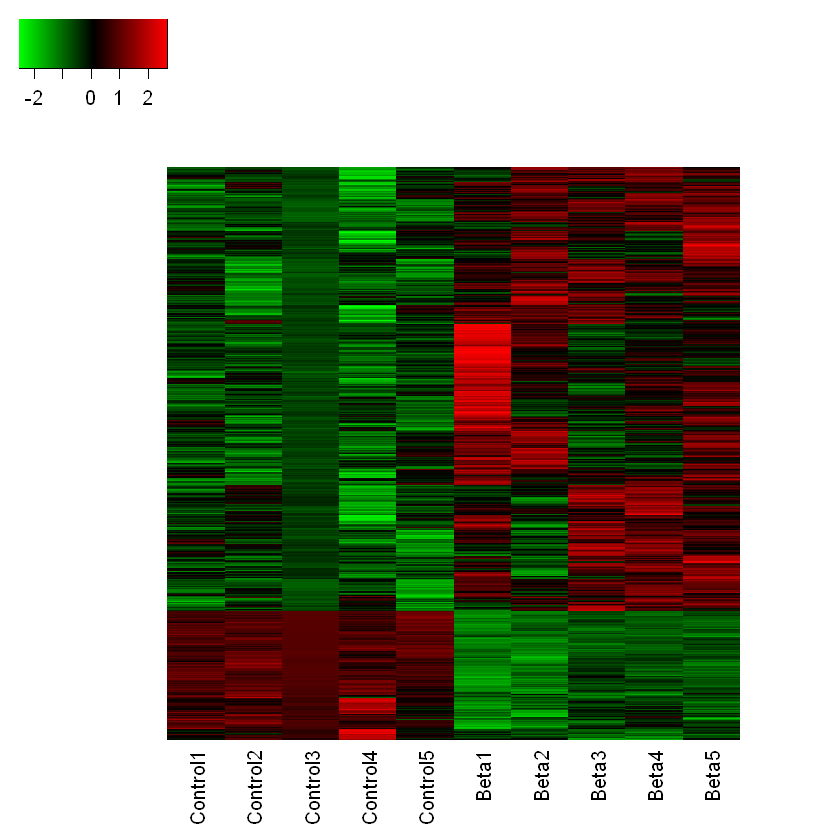

In [7]:
###heatmap
library(heatmap3)
library(ggplot2)
library(gplots)

vplot_sig<-subset(abc, PValue_fdr<.05 )
vvplotsig<-vplot_sig[,1:10]
vvplotsig<-as.matrix(vvplotsig)

lmno <- cpm(vvplotsig, prior.count=2, log=TRUE)

heatmap3(lmno, Rowv = NULL, Colv = NA,
  distfun = function(x) as.dist(1 - cor(t(x), use = "pa")),
  balanceColor = F,showColDendro = F,
  showRowDendro = F, col = greenred(1050), legendfun, method = "complete", ColAxisColors = 0,
  RowAxisColors = 0, hclustfun = hclust, reorderfun = function(d, w)
  reorder(d, w), add.expr, symm = FALSE,
  scale = "row", na.rm = TRUE, 
  ColSideWidth = 0.4, 
  file = "heatmap3.pdf", topN = NA, filterFun = sd, margins = c(5, 5), lasRow = 2, lasCol = 2,
  labRow =NA, labCol = NULL, main = NULL, xlab = NULL, ylab = NULL,
  keep.dendro = FALSE, verbose = getOption("verbose"))